# Multiple Variables
Continuing from the previous example, what if we want to do inference on something multi-dimensional?

In [1]:
# libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import sys
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

In [2]:
np.random.seed(0)

Let's take the example of a wave moving from left to right.
What if only some points are observed? Can we infer other points? We might also want to include information about correlations between points we observe and infer.

First we will set up our model. We have a function that initialises a wave and one that iterates a wave forward in time by `nt` timesteps of size `dt`.

In [3]:
def initialise_wave(nx, dx):
    """ Returns initial wave
    """
    # initial conditions
    h = torch.ones(nx)     
    h[int(.5 / dx):int(1 / dx + 1)] = 2  # set h = 2 between 0.5 and 1 
    return h

def iterate_wave(speed, h, nx, nt, dt, dx):
    """ Returns wave height after nt iterations, given initial height h
    """
    # propagate in time for nt steps, hn is the next step
    hn = torch.zeros(nx)
    for n in range(nt): 
        hn[0] = h[0]
        hn[1:] = h[1:] - speed * dt / dx * (h[1:] - h[0:-1])
        # set h to hn for next iteration
        h = hn
    return h

We define the model which samples from a latent variable, `speed`. The observed variable, `h`, is a function of this latent variable. The `true_h_model` function is used to find the the height of the wave from the speed, given the specific set up for this example. This function could in theory be swapped for more complex, non-linear function, possibly with more latent variables.

In [4]:
def true_h_model(speed, nx, nt, dt):
    dx = 2 / (nx-1) 
    # initial conditions
    h0 = initialise_wave(nx, dx)
    # iterate
    true_h = iterate_wave(speed, h0, nx, nt, dt, dx)
    return(true_h)


In [5]:
pyro.clear_param_store()

def model(guess, observed_inds, nx=21, nt=10, dt=0.025,                             
         plot_wave=False):
    """ what are input params  """
    # get pyro distribution of speed
    speed = pyro.sample("speed", dist.Normal(guess, 0.25))
    true_h = true_h_model(speed, nx, nt, dt)
    
    # observe with some measurement error
    obs_h = torch.zeros(nx)
    for i in pyro.plate("x_axis",nx):
        # each point on the x-axis is conditionally independent given the speed 
        obs_h[i] = pyro.sample("h_{}".format(str(i)),
                               dist.Normal(true_h[i],0.01))      

    if (plot_wave):
        h0 = initialise_wave(nx, 2 / (nx-1) )
        plt.plot(np.linspace(0, 2, nx), h0.numpy());
        plt.plot(np.linspace(0, 2, nx), obs_h.numpy());

    return(speed,obs_h)


Let's check how the output varies if we sample multiple times.

In [6]:
# Set up parameters
guess = 1.
nx = 21
nt = 10
dt = 0.025

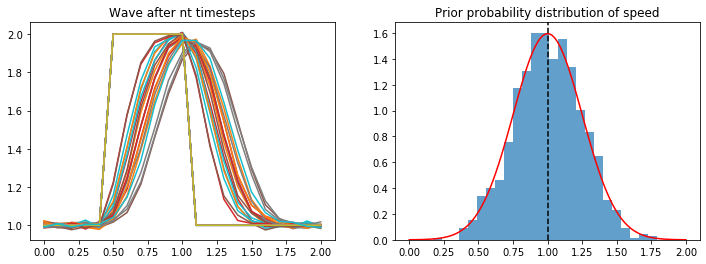

In [7]:
speed_uncond = []
fig = plt.figure(figsize=(12,4));
ax0 = plt.subplot2grid((1, 2), (0, 0));
for i in range(1000):
    plot_wave = True if i < 20 else False
    speed, h = model(guess, observed_inds=[], plot_wave=plot_wave)
    speed_uncond.append(speed)

plt.title("Wave after nt timesteps")
# Plot probability distribution of speed
ax1 = plt.subplot2grid((1, 2), (0, 1));
ax1.hist(speed_uncond, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(speed_uncond), c="k", ls="--");
x = np.linspace(0., 2., 100);
f = 1./(0.25*np.sqrt(2*np.pi))*np.exp(-(x-guess)**2/(2*0.25**2))
ax1.plot(x,f,color="red")
plt.title("Prior probability distribution of speed");

What if we observe some values of h, after some time. I will assume that these come from a wave moving with speed of 1.85, so we know the answer. If this is the speed we can work out the wave position that is observed. 

tensor([1.2403, 1.9080, 1.0004, 1.0000, 1.8808])


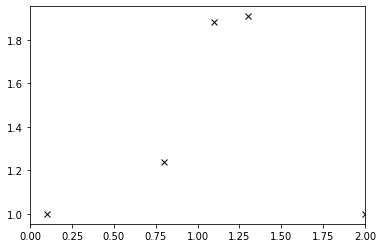

In [8]:
observed_speed = 1.85
full_observed_h = true_h_model(observed_speed, nx=21, nt=10, dt=0.025)

# Pick some random points that we observe
observed_inds = np.random.choice(len(h),size=5,replace=False)

not_observed_inds = [i for i in range(nx) 
                         if i not in observed_inds]
observed_h = full_observed_h[observed_inds]
print(observed_h)

# Put into data dictionary with named labels
keys = ["h_{}".format(str(i)) for i in observed_inds]
data = dict(zip(keys, observed_h))
# data = {"h_c":observed_h}
# Plot
plt.plot(np.linspace(0,2,nx)[observed_inds],observed_h.detach().numpy(),'kx');
plt.axis(xmin=0.,xmax=2);

In [9]:
print(data)

{'h_8': tensor(1.2403), 'h_13': tensor(1.9080), 'h_20': tensor(1.0004), 'h_1': tensor(1.), 'h_11': tensor(1.8808)}


In [10]:
conditioned_model = pyro.condition(model, data=data)

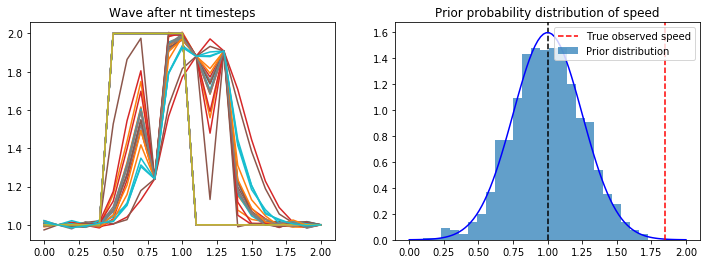

In [11]:
# Check this gives conditioned values fixed
guess = 1.
speed_cond  = []
fig = plt.figure(figsize=(12,4));
ax0 = plt.subplot2grid((1, 2), (0, 0));
for i in range(1000):
    plot_wave = True if i < 20 else False
    speed, h = conditioned_model(guess, observed_inds, plot_wave=plot_wave)
    speed_cond.append(speed)
plt.title("Wave after nt timesteps")
ax1 = plt.subplot2grid((1, 2), (0, 1));
ax1.hist(speed_cond, 25, density=True, alpha=0.7, label="Prior distribution");
ax1.axvline(np.mean(speed_cond), c="k", ls="--");
x = np.linspace(0., 2., 100);
f = 1./(0.25*np.sqrt(2*np.pi))*np.exp(-(x-guess)**2/(2*0.25**2))
ax1.plot(x,f,color="b");
ax1.axvline(np.mean(observed_speed), c="red", ls="--", label="True observed speed");
plt.legend()
plt.title("Prior probability distribution of speed");



What if we condition on wave output, can we get the wave speed needed to get this output (using fixed wave speed from before, the correct value should be 0.5)?

Now create the guide, with parameters that should move us towards observed values of the wave.

In [12]:
from torch.distributions import constraints

def parameterised_guide(guess, observed_inds, nx=21, nt=10, dt=0.025,  
                        plot_wave=False):
    # want to infer speed, and h_i at all values that we don't know them at
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(0.5), 
                   constraint=constraints.positive)

    speed = pyro.sample("speed", dist.Normal(a,b))
    true_h = true_h_model(speed, nx, nt, dt)
    d = pyro.param("d", torch.tensor(0.5),
                   constraint=constraints.positive)

    h = torch.zeros(nx)
    for i in pyro.plate("x_axis",nx):
        if (i in observed_inds):
            continue        
        h[i] = (pyro.sample("h_{}".format(str(i)),dist.Normal(true_h[i],d)) )
    
    if plot_wave:
        h = torch.detach(h)
        plt.plot(np.linspace(0,2,nx),h.numpy(),'bx')
    
    return(speed,h)


In [13]:
# Plotting function for guide
def plot_guide_wave(nx, guess, observed_h, observed_inds):
    plt.plot(np.linspace(0,2,nx)[observed_inds],
             observed_h.numpy(),'rx',label="Observed");
    not_observed_inds = [i for i in range(nx) 
                         if i not in observed_inds]
    speed,h = parameterised_guide(guess, observed_inds)
    plt.plot(np.linspace(0,2,nx)[not_observed_inds],
             h.detach().numpy()[not_observed_inds],'bx',alpha=0.2,label="Sample");
    for i in range(50):
        speed,h = parameterised_guide(guess, observed_inds)
        plt.plot(np.linspace(0,2,nx)[not_observed_inds],
             h.detach().numpy()[not_observed_inds],'bx',alpha=0.2);
    plt.axis(xmin=0.,xmax=2);

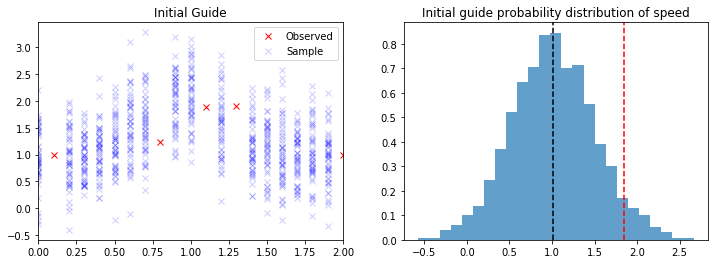

In [14]:
# Check this gives conditioned values fixed
fig = plt.figure(figsize=(12,4));
ax0 = plt.subplot2grid((1, 2), (0, 0));
plot_guide_wave(nx,guess,observed_h,observed_inds)
plt.legend();
speed_guide = [parameterised_guide(guess, observed_inds)[0].item() for i in range(1000)]
plt.title('Initial Guide')
ax1 = plt.subplot2grid((1, 2), (0, 1));
ax1.hist(speed_guide, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(speed_guide), c="k", ls="--",label="Guide");
ax1.axvline(np.mean(observed_speed), c="red", ls="--",label="True observed speed");
plt.title("Initial guide probability distribution of speed");

In [15]:
param_store = pyro.get_param_store()
param_names = list(pyro.get_param_store().get_all_param_names())
print(param_names)
print(param_store['a'],param_store['b'],param_store['d'])

['a', 'b', 'd']
tensor(1., requires_grad=True) tensor(0.5000, grad_fn=<AddBackward0>) tensor(0.5000, grad_fn=<AddBackward0>)


Iteration 0


<Figure size 720x720 with 0 Axes>

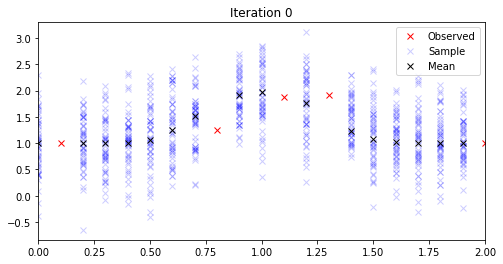

Iteration 1000


<Figure size 432x288 with 0 Axes>

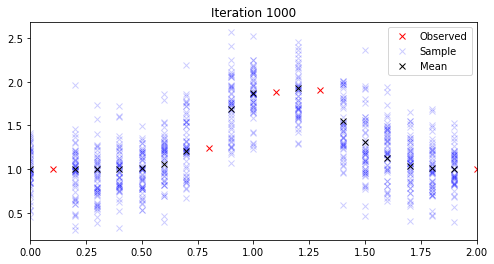

Iteration 2000


<Figure size 432x288 with 0 Axes>

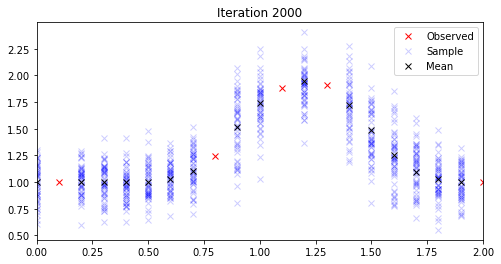

Iteration 3000


<Figure size 432x288 with 0 Axes>

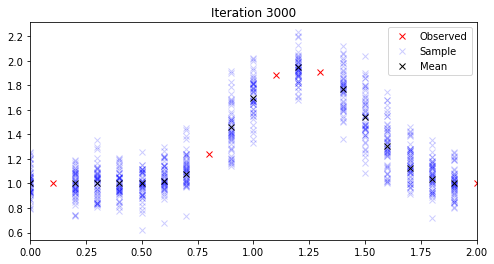

Iteration 4000


<Figure size 432x288 with 0 Axes>

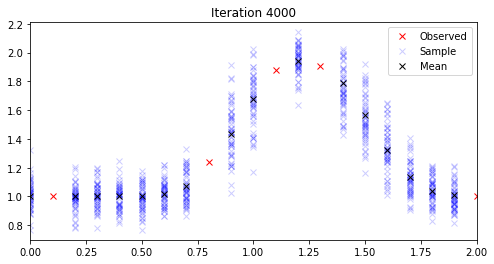

Iteration 5000


<Figure size 432x288 with 0 Axes>

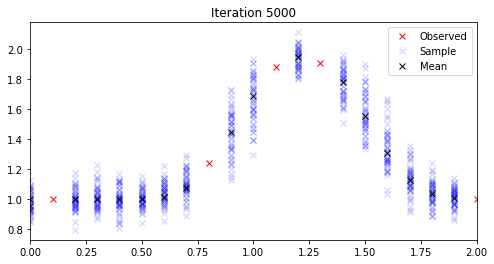

Iteration 6000


<Figure size 432x288 with 0 Axes>

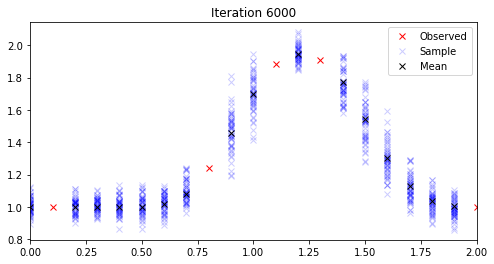

Iteration 7000


<Figure size 432x288 with 0 Axes>

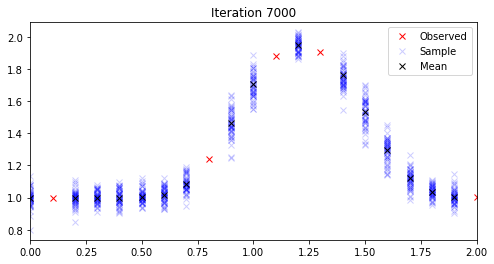

In [ ]:
%%time
from pyro.optim import Adam
pyro.clear_param_store()
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_model, 
                     guide=parameterised_guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO()
                     )

num_steps = 10000
# Save all parameters and losses
params = np.zeros((num_steps,len(param_names)))
losses = np.zeros(num_steps)
fig = plt.figure(figsize=(10,10));

plot_ind = 0
for t in range(num_steps):
    losses[t] = svi.step(guess=guess, 
                         observed_inds=observed_inds)
    params[t,:] = [pyro.param(param_names[i]).item() for i in range(len(param_names))]
    
    if (t%1000==0.):
        print('Iteration {}'.format(str(t)))
        plt.clf();
        fig = plt.figure(figsize=(8, 4));
        plot_guide_wave(nx, guess, observed_h, observed_inds)
        speed_mean = pyro.param("a").item()
        true_h = true_h_model(speed_mean, nx=21, nt=10, dt=0.025)
        plt.plot(np.linspace(0,2,nx)[not_observed_inds],
         true_h.numpy()[not_observed_inds], 'kx', lw=2,label="Mean");
        plt.legend();
        plt.title('Iteration {}'.format(str(t)));
        plt.show();
        
fig = plt.figure(figsize=(10, 10));
ax = plt.subplot2grid((2, 5), (1, 0), colspan=4);
ax.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("loss");

In [ ]:
print("a = ",pyro.param("a").item())
print("b = ", pyro.param("b").item())
print("d = ", pyro.param("d").item())


fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((4, 1), (0, 0));
for i in range(nx):
    ax1.plot(params[:,0])
plt.title('a');

ax2 = plt.subplot2grid((4, 1), (1, 0));
for i in range(nx):
    ax2.plot(params[:,1])
plt.title('b');

ax3 = plt.subplot2grid((4, 1), (2, 0));
for i in range(nx):
    ax3.plot(params[:,2:])
plt.title('d');

plt.tight_layout();

This is looks mostly converged. If we run for longer, we find the parameter `b` keeps decreasing. This is because it is the variance on `speed`. However, we only had one observation therefore we don't actually have a distribution for `speed`- its just a number. 

In [ ]:
# Check this posterior
fig = plt.figure(figsize=(12,4));
ax0 = plt.subplot2grid((1, 2), (0, 0));
ax0.plot(np.linspace(0.,2.,nx),full_observed_h.detach().numpy(),'rx-',alpha=0.7,label="True height")
plot_guide_wave(nx,guess,observed_h,observed_inds)
speed_guide_final = [parameterised_guide(guess, observed_inds)[0].item() for i in range(1000)]
speed_mean = pyro.param("a").item()
true_h = true_h_model(speed_mean, nx=21, nt=10, dt=0.025)
plt.plot(np.linspace(0,2,nx)[not_observed_inds],
         true_h.numpy()[not_observed_inds], 'kx', lw=2);
plt.title("Final Guide")
ax1 = plt.subplot2grid((1, 2), (0, 1));
ax1.hist(speed_guide_final, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(speed_guide_final), c="k", ls="--",label="Guide speed");
ax1.axvline(np.mean(observed_speed), c="red", ls="--",label="True speed");
plt.title("Final guide probability distribution of speed");

In [ ]:
param_store = pyro.get_param_store()
print(param_store.keys())
print(param_store['a'])
print(param_store['b'])
print(param_store['d'])

## MAP
Try the same with MAP inference.

In [ ]:
def MAP_guide(guess, observed_inds, nx=21, nt=10, dt=0.025,  
              plot_wave=False):
    # want to infer speed, and h_i at all values that we don't know them at
    a = pyro.param("a", torch.tensor(guess))
    speed = pyro.sample("speed", dist.Delta(a))
    true_h = true_h_model(speed, nx, nt, dt)

    h = torch.zeros(nx)
    for i in pyro.plate("x_axis",nx):
        if (i in observed_inds):
            continue        
        h[i] = (pyro.sample("h_{}".format(str(i)),dist.Delta(true_h[i])) )
    
    if plot_wave:
        h = torch.detach(h)
        plt.plot(np.linspace(0,2,nx),h.numpy(),'bx')
    
    return(speed,h)



In [ ]:
%%time
from pyro.optim import Adam
pyro.clear_param_store()
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_model, 
                     guide=MAP_guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO()
                     )

num_steps = 5000
# Save all parameters and losses
params = np.zeros(num_steps)
losses = np.zeros(num_steps)
fig = plt.figure(figsize=(10,10));

plot_ind = 0
for t in range(num_steps):
    losses[t] = svi.step(guess=guess, 
                          observed_inds=observed_inds)
    params[t] = pyro.param("a").item()
    
    if (t%1000==0.):
        print('Iteration {}'.format(str(t)))
        plt.clf();
        fig = plt.figure(figsize=(8, 4));
        plt.plot(np.linspace(0,2,nx)[observed_inds],
             observed_h.numpy(),'rx',label="Observed");
        speed_mean = pyro.param("a").item()
        true_h = true_h_model(speed_mean, nx=21, nt=10, dt=0.025)
        plt.plot(np.linspace(0,2,nx)[not_observed_inds],
         true_h.numpy()[not_observed_inds], 'kx', lw=2, label="Mean");
        plt.title('Iteration {}'.format(str(t)));
        plt.legend();
        plt.show();
        
fig = plt.figure(figsize=(10, 10));
ax = plt.subplot2grid((2, 5), (1, 0), colspan=4);
ax.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("loss");

## What if we have multiple observations
The parameter for the variance on the speed, `b`, keeps decreasing as we iterate. This is because we only had 1 observation, so only 1 value of `speed`. In the next section, I will try and make this work for more than one observation.

In [ ]:
def model_multiple_obs(n_data, guess, observed_inds, nx=21, nt=10, dt=0.025):
    us, hs = [], []
    for n in pyro.plate("observations",n_data):
    #with pyro.iarange('observe_data', n_data) as ind:
        model(guess, observed_inds, nx, nt, dt)
   

In [ ]:
conditioned_model = pyro.condition(model_multiple_obs,data=data)

In [ ]:
def conditioned_model_multiple_obs(data, guess, observed_inds, 
                                   nx=21, nt=10, dt=0.025):
    return pyro.condition(model_multiple_obs, data=data)(len(data), guess, 
                                                         observed_inds, 
                                                         nx, nt, dt)


## we should put speed inside plate: each observation has iid speed


In [ ]:
# Pick some random points that we observe
observed_inds = np.random.choice(len(h),size=5,replace=False)
not_observed_inds = [i for i in range(nx) if i not in observed_inds]

# Take some random samples
n_data = 10
observed_speed = dist.Normal(1.85,0.3).sample(torch.Size([n_data]))
full_observed_h = true_h_model(observed_speed, nx=21, nt=10, dt=0.025, n_data=n_data)

# Put into data dictionary with named labels
data = {"h_{}".format(str(i)): full_observed_h[:,i] for i in observed_inds} 

data

In [ ]:
def initialise_wave(nx, dx, n_data=1):
    """ Returns initial wave
    """
    # initial conditions
    # h should be the size of the data
    h = torch.ones((n_data,nx))    
    h[:,int(.5 / dx):int(1 / dx + 1)] = 2  # set h = 2 between 0.5 and 1 
    return h

def iterate_wave(speed, h, nx, nt, dt, dx, n_data=1):
    """ Returns wave height after nt iterations, given initial height h
    """
    # propagate in time for nt steps, hn is the next step
    hn = torch.zeros(h.shape)
    for n in range(nt): 
        hn[:,0] = h[:,0]
        hn[:,1:] = h[:,1:] - speed.reshape(-1,1) * dt / dx * (h[:,1:] - h[:,0:-1])
        # set h to hn for next iteration
        h = hn
    return h

In [ ]:
def true_h_model(speed, nx, nt, dt, n_data=1):
    dx = 2 / (nx-1) 
    # initial conditions
    h0 = initialise_wave(nx, dx, n_data)
    # iterate
    true_h = iterate_wave(speed, h0, nx, nt, dt, dx, n_data)
    return(true_h)



In the following guide, we also introduce the possibility that parameter `d`, the variance on the height field, can vary depending on the height. This gives more parameters to optimise.

In [ ]:
from torch.distributions import constraints

def parameterised_guide_multiple_obs(data, n_data, guess, observed_inds, nx=21, nt=10, dt=0.025,     
                        plot_wave=False):
    h = torch.zeros((n_data,nx))
    with pyro.plate('observe_data', n_data) as ind:
        # want to infer speed, and h_i at all values that we don't know them at
        a = pyro.param("a", torch.tensor(guess))
        b = pyro.param("b", torch.tensor(0.5), 
                       constraint=constraints.positive)

        speed = pyro.sample("speed", dist.Normal(a,b))
        true_h = true_h_model(speed, nx, nt, dt, n_data)
        

        for i in pyro.plate("x_axis",nx):
            if (i in observed_inds):
                continue        
            d = pyro.param("d_{}".format(str(i)), torch.tensor(0.5),
                       constraint=constraints.positive)
            h[ind,i] = (pyro.sample("h_{}".format(str(i)),dist.Normal(true_h[ind,i],d)) )

        if plot_wave:
            h = torch.detach(h)
            plt.plot(np.linspace(0,2,nx),h.numpy(),'bx')
    
    
    return speed,h


In [ ]:
pyro.clear_param_store()

def conditioned_model_multiple_obs(data, n_data, guess, observed_inds, nx=21, nt=10, dt=0.025,                             
         plot_wave=False):
    """ what are input params  """
    obs_h = torch.zeros((n_data,nx))
    with pyro.plate('observe_data', n_data) as ind:
        # get pyro distribution of speed
        speed = pyro.sample("speed", dist.Normal(guess, 0.25))
        
        true_h = true_h_model(speed, nx, nt, dt, n_data)


        # observe with some measurement error
        for i in pyro.plate("x_axis",nx):
            # each point on the x-axis is conditionally independent given the speed 
            if i in observed_inds:
                obs_h[ind,i] = pyro.sample("h_{}".format(str(i)),
                            dist.Normal(true_h[ind,i],0.01),
                            obs = data["h_{}".format(str(i))].index_select(0,ind))
            else: 
                obs_h[ind,i] = pyro.sample("h_{}".format(str(i)),
                            dist.Normal(true_h[ind,i],0.01))

    if (plot_wave):
        h0 = initialise_wave(nx, 2 / (nx-1) )
        plt.plot(np.linspace(0, 2, nx), h0.numpy());
        plt.plot(np.linspace(0, 2, nx), obs_h.numpy());

    return(speed,obs_h)




In [ ]:
from collections import OrderedDict
# Plotting function for guide
def plot_guide_wave_multiple_obs(nx, guess, observed_h, observed_inds, n_data, n_samples):
    for i in observed_inds:
        observed_hi = data["h_{}".format(i)]
        for n in range(n_data):
            plt.plot(np.linspace(0,2,nx)[i],
             observed_hi[n].detach().numpy(),'rx',label="Observed");
    # Sampled
    not_observed_inds = [i for i in range(nx) if i not in observed_inds]
    speed,h = parameterised_guide_multiple_obs(None, n_samples, guess, observed_inds)
    for i in range(n_samples):
        plt.plot(np.linspace(0,2,nx)[not_observed_inds],
                 h[i,:].detach().numpy()[not_observed_inds],'bx',
                 alpha=0.2, label="Sample");
    plt.axis(xmin=0.,xmax=2);
    handles, labels = plt.gca().get_legend_handles_labels();
    by_label = OrderedDict(zip(labels, handles));
    plt.legend(by_label.values(), by_label.keys());

In [ ]:
%%time
from pyro.optim import Adam
pyro.clear_param_store()
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_model_multiple_obs, 
                     guide=parameterised_guide_multiple_obs,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO()
                     )

num_steps = 10000
# Save all parameters and losses
params = np.zeros((num_steps,len(param_names)))
losses = np.zeros(num_steps)
fig = plt.figure(figsize=(10,10));

svi.step(data, n_data, guess, observed_inds)
param_names = list(pyro.get_param_store().get_all_param_names())
print(param_names)

plot_ind = 0
for t in range(num_steps):
    losses[t] = svi.step(data, n_data, guess, observed_inds)
    params[t,:] = [pyro.param(param_names[i]).item() 
                   for i in range(len(param_names))]
    
    if (t%1000==0.):
        print('Iteration {}'.format(str(t)))
        plt.clf();
        fig = plt.figure(figsize=(8, 4));
        plot_guide_wave_multiple_obs(nx, guess, full_observed_h, observed_inds, 
                                     n_data, n_samples=50);
        plt.show();
        
fig = plt.figure(figsize=(10, 10));
ax = plt.subplot2grid((2, 5), (1, 0), colspan=4);
ax.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("loss");


In [ ]:
print("a = ",pyro.param("a").item())
print("b = ", pyro.param("b").item())
#print("d = ", pyro.param("d").item())


fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((4, 1), (0, 0));
for i in range(nx):
    ax1.plot(params[:,0])
plt.title('a');

ax2 = plt.subplot2grid((4, 1), (1, 0));
for i in range(nx):
    ax2.plot(params[:,1])
plt.title('b');

ax3 = plt.subplot2grid((4, 1), (2, 0));
for i in range(nx):
    ax3.plot(params[:,2:])
plt.title('d');

plt.tight_layout();

In [ ]:
# Check this posterior
fig = plt.figure(figsize=(12,4));
ax0 = plt.subplot2grid((1, 2), (0, 0));
#ax0.plot(np.linspace(0.,2.,nx),full_observed_h.detach().numpy(),'rx-',alpha=0.7,label="True height")
#plot_guide_wave_multiple_obs(nx, guess, full_observed_h, observed_inds, 
#                                     n_data, n_samples=50);
#speed_guide_final = [parameterised_guide_multiple_obs(data, n_data,
#                                                      guess, observed_inds)[0].item() 
#                     for i in range(10)]
a = pyro.param("a")
b = pyro.param("b")

speed_guide_final = [dist.Normal(a,b).sample() for i in range(1000)]
true_h = true_h_model(speed_mean.reshape(-1,1), nx=21, nt=10, dt=0.025)

ax1 = plt.subplot2grid((1, 2), (0, 1));
ax1.hist(speed_guide_final, 25, density=True, alpha=0.7);
ax1.axvline(a, c="k", ls="--",label="Guide speed");
ax1.axvline(observed_speed, c="red", ls="--",label="True speed mean");
#true_observed_speed = dist.Normal(1.85,0.3).sample(torch.Size([n_data]))

ax1.hist(observed_speed, 25, color="red", ls="--",label="True speed samples", alpha=0.7);
plt.legend();



plt.title("Final guide probability distribution of speed");
